In [2]:
import numpy as np
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as pl
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='viridis')  # low dpi (dots per inch) yields small inline figures

#Set working directory
wd = '/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/visual/'

results_file = wd + '/Embryo10Xv6_genes_PCAbatchCorrected.h5ad'
results_fileMerged = wd + '/Embryo10Xv6_genes_PCAbatchCorrected_mergedAGA.h5ad'

In [2]:
##====== Read normalised counts ======##

filename_data = '/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/visual/countsData_norm.mtx'
filename_gene_names = wd + '/genes.txt'
filename_barcodes = wd + '/cells.txt'

print('reading counts...')
adata_all_cells = sc.read(filename_data, cache=True).transpose()
print('done')
print('reading genes...')
adata_all_cells.var_names = np.genfromtxt(filename_gene_names, dtype='str')
print('done')
print('reading cells...')
adata_all_cells.obs_names = np.genfromtxt(filename_barcodes, dtype='str')
print('done')

reading counts...
... reading from cache file cache/rds-project-bg200-rds-bg200-hphi-gottgens-users-mlnt2-PhD_MT06-visual-countsData_norm.h5ad
done
reading genes...
done
reading cells...
done


In [5]:
##====== Substitute gene IDs for geneNames ======##

genes = np.genfromtxt(filename_gene_names, dtype='str')

geneNameFilename = wd + 'features.tsv' #this can be gathered from the features.tsv.gz files in cellranger's output
geneName = pd.read_table(geneNameFilename,delimiter="\t",header=None,names=["geneID","geneName","Expression"])

geneName = geneName.set_index(geneName.geneID)

geneNameData = geneName.loc[genes,'geneName']
adata_all_cells.var_names = geneNameData
adata_all_cells.var['geneID'] = genes

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
##====== Check number of total cells -rows- ======##

adata_all_cells.shape


(172995, 30725)

In [7]:
##====== Read metadata file and set index to cell ======##

metadataFilename = '/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/7_clusters/meta.tab'
meta = pd.read_table(metadataFilename,delimiter="\t",header=0)
meta = meta.set_index(meta.cell)

In [8]:
##======  Check number of total cells in metadata ======##

meta.shape

(172995, 11)

In [9]:
##======  Filter metadata so that the cells correspond to those in the counts matrix ======##
metadata00 = pd.DataFrame(np.array(meta)[np.array([cell in adata_all_cells.obs_names for cell in meta['cell']]),:])
metadata00.columns = meta.columns 

metadata00 = metadata00.set_index(metadata00.cell)
metadata00.shape

(172995, 11)

In [11]:
##======  Check columns in metadata ======##

metadata00.columns 

##======  Add metadata to adata ======##

adata_all_cells.obs['sample'] = list(metadata00.loc[:,'sample'])
adata_all_cells.obs['stage'] = list(metadata00.loc[:,'stage'])
adata_all_cells.obs['batch'] = list(metadata00.loc[:,'batch'])
adata_all_cells.obs['doub.density'] = list(metadata00.loc[:,'doub.density'])
adata_all_cells.obs['doublet'] = list(metadata00.loc[:,'doublet'])
adata_all_cells.obs['cluster'] = list(metadata00.loc[:,'cluster'])
adata_all_cells.obs['clustersub'] = list(metadata00.loc[:,'cluster.sub'])
adata_all_cells.obs['clusterstage'] = list(metadata00.loc[:,'cluster.stage'])
adata_all_cells.obs['stripped'] = list(metadata00.loc[:,'stripped'])
adata_all_cells.obs['clusterIdx'] = list(metadata00.loc[:,'cluster']-1)
adata_all_cells.obs['clustercat'] = ['cluster'+ str(name) for name in list(metadata00.loc[:,'cluster'])]
# adata_all_cells.obs['celltype_new'] = list(metadata00.loc[:,'celltype_new'])
# adata_all_cells.obs['colour_new'] = list(metadata00.loc[:,'colour_new'])
# adata_all_cells.obs['celltype'] = list(metadata00.loc[:,'celltype'])
# adata_all_cells.obs['clusterMergedHierarchy'] = list(metadata00.loc[:,'clusterMergedHierarchy'])

In [14]:
##======  Read batch corrected PCA ======##

PCAfilename = wd + '/PCAall_20200414.mtx'
filename_cells = wd + '/pcaall_cellnames_20200414.tab'
#filename_clustersAll = wd + 'data/cellTypes_20180215.txt'
print('reading counts')
adataPCA = sc.read(PCAfilename, cache=True) #.transpose() ## we remove this because our PCA matrix is in correct orientation
#print('reading genes')
#adata_all_genes.var_names = np.genfromtxt(filename_gene_names, dtype='str')
print('reading cells')
adataPCA.obs_names = np.genfromtxt(filename_cells, dtype='str')
adataPCA.shape

reading counts
... reading from cache file cache/rds-project-bg200-rds-bg200-hphi-gottgens-users-mlnt2-PhD_MT06-visual-PCAall_20200414.h5ad
reading cells


(146133, 50)

In [16]:
##======  Filter those cells that are in PCA - these will be the passed-QC cells ======##

adata = adata_all_cells[np.array([cell in adataPCA.obs_names for cell in adata_all_cells.obs_names]),:]

##======  Check how many cells passed QC ======##

adata.shape 


##======  Add batch corrected PCA to adata object ======##

adata.obsm['X_pca'] = adataPCA.X.todense()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
#=Delete old variables if transfer goes smoothly=#

#del adataPCA
#del adata_all_cells

In [17]:
##======  Filter out stripped nuclei - they should be already filtered out but just in case ======##

metadata0 = pd.DataFrame(np.array(meta)[np.array([cell == False for cell in meta['stripped']]),:])
metadata0.columns = meta.columns 

metadata0 = metadata0.set_index(metadata0.cell)
#metadata0

##======  Filter out doublets - they should be already filtered out but just in case ======##

metadata1 = pd.DataFrame(np.array(metadata0)[np.array([cell == False for cell in metadata0['doublet']]),:])
metadata1.columns = metadata0.columns 

metadata1 = metadata1.set_index(metadata1.cell)
#metadata1

##======  Filter out these cells in adata - you should see they are the same dimensions ======##

adata = adata[np.array([cell in metadata0['cell'] for cell in adata.obs_names]),:]
adata.shape

(146133, 30725)

In [18]:
##======  Make cluster names of the clustersub column unique ======##

stringClust = list()
for i in range(0,len(adata.obs['cluster'])):
    stringClust.append(str(int(adata.obs['cluster'][i]))+str(int(adata.obs['clustersub'][i])))

adata.obs['clusterSubUnique'] = stringClust


##======  Read tSNE file ======##

tSNEfilename = wd + '/tsne.tab'
tSNE = pd.read_table(tSNEfilename,delimiter=" ",names=["tsne1","tsne2"])
# tSNE = pd.read_table(tSNEfilename,delimiter="\t",header=None,names=["tsne1","tsne2","cluster","celltype"])

Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [19]:
##======  Add tSNE to adata ======##

adata.obs['tsne1'] = list(tSNE['tsne1'])
adata.obs['tsne2'] = list(tSNE['tsne2'])
#adata.obs['clustertsne'] = list(tSNE['cluster'])
#adata.obs['celltype'] = list(tSNE['celltype_new'])

tsne_x = [float(i) for i in tSNE.loc[:,'tsne1']]
tsne_y = [float(i) for i in tSNE.loc[:,'tsne2']]

coords_matrix = np.array([tsne_x, tsne_y])
print(coords_matrix.T.shape)
#Add coordinates in to adata file
adata.obsm['X_tsne'] = np.array(coords_matrix.T)

##======  Check cell types ======##
# this probably doesn't currently work because I don't have celltype and cluster - MT
# np.unique(adata.obs['celltype'])
          
          
##======  Read UMAP file ======##

UMAPfilename = wd + 'umap.tab'

UMAP = pd.read_table(UMAPfilename,delimiter=" ",header=None,names=["umap1","umap2"])

UMAP_x = [float(i) for i in UMAP.loc[:,'umap1']]
UMAP_y = [float(i) for i in UMAP.loc[:,'umap2']]

coords_matrix = np.array([UMAP_x, UMAP_y])
print(coords_matrix.T.shape)

#Add coordinates in to adata file
adata.obsm['X_umap'] = np.array(coords_matrix.T)


(146133, 2)
(146133, 2)


In [20]:
##======  Write results ======##

sc.write(results_file,adata)

## stored at "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/visual/Embryo10Xv6_genes_PCAbatchCorrected.h5ad"

... storing 'stage' as categorical
... storing 'clustercat' as categorical
... storing 'clusterSubUnique' as categorical


In [3]:
##======  Read adata object ======##

adata = sc.read(results_file)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata.obs

sample stage  batch  doub.density  doublet  cluster  clustersub  \
index                                                                          
cell_1            1   GD7      1      6.367198    False      4.0         1.0   
cell_2            1   GD7      1      0.000000    False      2.0         1.0   
cell_4            1   GD7      1     43.049333    False      4.0         3.0   
cell_5            1   GD7      1      8.402787    False     10.0         2.0   
cell_6            1   GD7      1     61.325550    False      4.0         2.0   
...             ...   ...    ...           ...      ...      ...         ...   
cell_172991      26   GD9      1      1.844210    False     13.0         7.0   
cell_172992      26   GD9      1      6.678890    False     16.0         9.0   
cell_172993      26   GD9      1      2.266589    False     13.0         1.0   
cell_172994      26   GD9      1      7.826140    False     16.0         9.0   
cell_172995      26   GD9      1     29.612056    False     21.0         8.0   

             clusterstage  stripped  clusterIdx   clustercat clusterSubUnique  \
index                                                                           
cell_1                8.0     False         3.0   cluster4.0               41   
cell_2               13.0     False         1.0   cluster2.0               21   
cell_4                3.0     False         3.0   cluster4.0               43   
cell_5               15.0     False         9.0  cluster10.0              102   
cell_6                9.0     False         3.0   cluster4.0               42   
...                   ...       ...         ...          ...              ...   
cell_172991          19.0     False        12.0  cluster13.0              137   
cell_172992           2.0     False        15.0  cluster16.0              169   
cell_172993          19.0     False        12.0  cluster13.0              131   
cell_172994           2.0     False        15.0  cluster16.0              169   
cell_172995          23.0     False        20.0  cluster21.0              218   

                 tsne1      tsne2  
index                              
cell_1       -9.612870  16.276639  
cell_2       -2.122766 -19.865110  
cell_4      -11.245791  11.410026  
cell_5      -14.380720  -2.360212  
cell_6        4.962400  15.951718  
...                ...        ...  
cell_172991  -3.099240 -10.922396  
cell_172992   7.330758  -7.500678  
cell_172993  -1.848312 -11.060558  
cell_172994   7.231826  -7.499310  
cell_172995 -17.923657   3.450960  

[146133 rows x 14 columns]

In [25]:
adata.var_names_make_unique


##====== Create colour palette for cell types ======##

all_colours = {
    "Allantois" : "#532C8A",#[32] "Allantois"                                   
    "Cardiac mesenchyme" :  "#F7901D",#[23] "Cardiac mesenchyme"                          
    "Cardiomyocytes" :  "#B51D8D",#[34] "Cardiomyocytes"                              
    "Def. endoderm" : "#F397C0",#[24] "Def. endoderm"    
    "Early mixed mesoderm" :  "#C594BF",#[7] "Early mixed mesoderm"                        
    "Early posterior mesoderm" :  "#DFCDE4",#[26] "Early ExE mesoderm"    
    "Early neurectoderm" :  "#A0CC47",#[10] "Early neurectoderm"                              
    "Early paraxial mesoderm" :  "#3F84AA",#[17] "Early paraxial mesoderm"                     
    "Endothelium" :  "#B3793B",#[20] "Endothelium"                                 
    "Epiblast" :  "#683612",#[1] "Epiblast"  
    "Erythroid 1" :  "#C72228",#[15] "Erythroid 1"                                 
    "Erythroid 2" :  "#EF4E22",#[37] "Erythroid2"                                  
    "ExE ectoderm 1" :  "#989898",#[30] "ExE ectoderm 1"                              
    "ExE ectoderm 2" :  "#333333",#[4] "ExE ectoderm 2"                              
    "ExE endoderm" : "#7F6874",#[5] "ExE endoderm"                                
    "ExE mesoderm" :  "#7253A2",#[12] "ExE mesoderm"                                
    "Forebrain" :  "#65A83E",#[8] "Forebrain"   
    "Foregut" :  "#EF5A9D",#[19] "Foregut"                                     
    "Haemato-endothelial progenitors" :  "#FBBE92",#[9] "Hemato-endothelial progenitors"              
    "Intermediate mesoderm" :  "#139992",#[31] "Intermediate mesoderm"                       
    "Pharyngeal mesoderm" :  "#C9EBFB",#[13] "Late mixed mesoderm"                         
    "Late paraxial mesoderm" :  "#8DB5CE",#[33] "Late paraxial mesoderm (presomitic mesoderm)"
    "Midgut/Hindgut":  "#CE4E82",#[35] "Midgut/Hindgut"                              
    "Midbrain/Hindbrain" :  "#354E23",#[11] "Midbrain/Hindbrain"                          
    "Trunk neural crest" :  "#77783C",#[18] "Neural crest"
    "NMP" :  "#8EC792",#[14] "NMPs"                                         
    "Notochord" :  "#0F4A9C",#[21] "Notochord"                                   
    "PGC" :  "#FACB12",#[25] "PGC"                                         
    "Placodes" :  "#BBDCA8",#[27] "Placodes"                                    
    "Parietal endoderm" :  "#1A1A1A",#[29] "Parietal endoderm"                           
    "Cranial neural crest" :  "#C3C388",#[36] "Pre-migratory neural crest"                  
    "Primitive Streak" :  "#DABE99",#[2] "Primitive Streak"    
    "Somites" :  "#005579",#[16] "Somites"                                     
    "Spinal cord" :  "#CDE088",#[38] "Spinal cord"                                 
    "Surface ectoderm" : "#FFF574",#[22] "Surface ectoderm"                            
    "Visceral endoderm" : "#F6BFCB",#[3] "Visceral endoderm"   
    "New": "gray",
    "Unknown_grey" : "#808080"

}#light green


               

colPalette = [all_colours[i] for i in sorted(np.unique(adata.obs['celltype']))]

KeyError: 'celltype'

In [28]:
##====== Create colour palettes for stages ======##

bluePal = [ "#E3FCFA","#C1ECEF", "#A3D4E3", "#86B8D6","#6C98CA","#5476BE","#3E52B1","#2B2DA5","#2B1999"]

spectralPal = [ "#D53E4F","#F46D43","#FDAE61","#FFFFBF","#FEE08B","#E6F598","#ABDDA4","#3288BD", "#66C2A5","#A9A9A9"]


##====== Create colour palette for gene expression profiles ======##

from matplotlib.colors import LinearSegmentedColormap
rmap = LinearSegmentedColormap.from_list(name='gene_cmap',
                                         colors=['lightgrey', 'thistle', 'red', 'darkred'])

cmap = LinearSegmentedColormap.from_list(name='gene_cmap',
                                         colors=["#BFBFBF","#6495ED","#000000"])

In [1]:
##======  Read adata object ======##

adata = sc.read(results_file)

NameError: name 'sc' is not defined

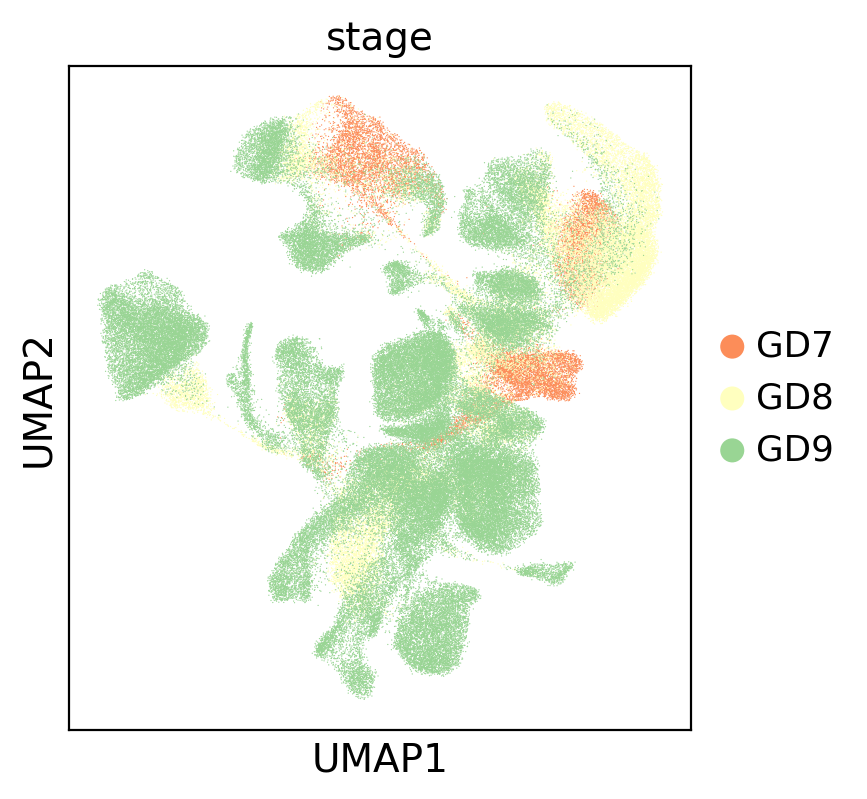

In [29]:
##======  Plot UMAP coloured by time-points ======##
spectralPal = [ "#FC8D59","#FFFFBF","#99D594"]
sc.pl.scatter(adata,color='stage',basis="umap",palette=spectralPal)

In [30]:
##======  Check number of unique clusters ======##

len(np.unique(adata.obs['clusterSubUnique']))

##======  Compute diffusion maps using the batch corrected PCA space ======##

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, use_rep='X_pca', 
                knn=True, random_state=0, method='umap', metric='euclidean', metric_kwds={}, copy=False)

sc.tl.diffmap(adata)

computing neighbors


/home/mlnt2/.local/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../home/mlnt2/.local/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/mlnt2/.local/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../home/mlnt2/.local/lib/python3

    finished (0:00:41)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99952364 0.9990438  0.9984142  0.99763924 0.9971266
     0.99702555 0.996451   0.99615765 0.99594504 0.995175   0.99443233
     0.99429005 0.9932365  0.9931375 ]
    finished (0:00:15)


computing neighbors


/home/mlnt2/.local/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../home/mlnt2/.local/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/mlnt2/.local/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../home/mlnt2/.local/lib/py

    finished (0:00:26)
running PAGA
    finished (0:00:45)


/home/mlnt2/jupyter-env/lib/python3.6/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


the obs value 'clusterSubUnique' has more than 103 categories. Uniform 'grey' color will be used for all categories.


TypeError: paga() got an unexpected keyword argument 'threshold_solid'

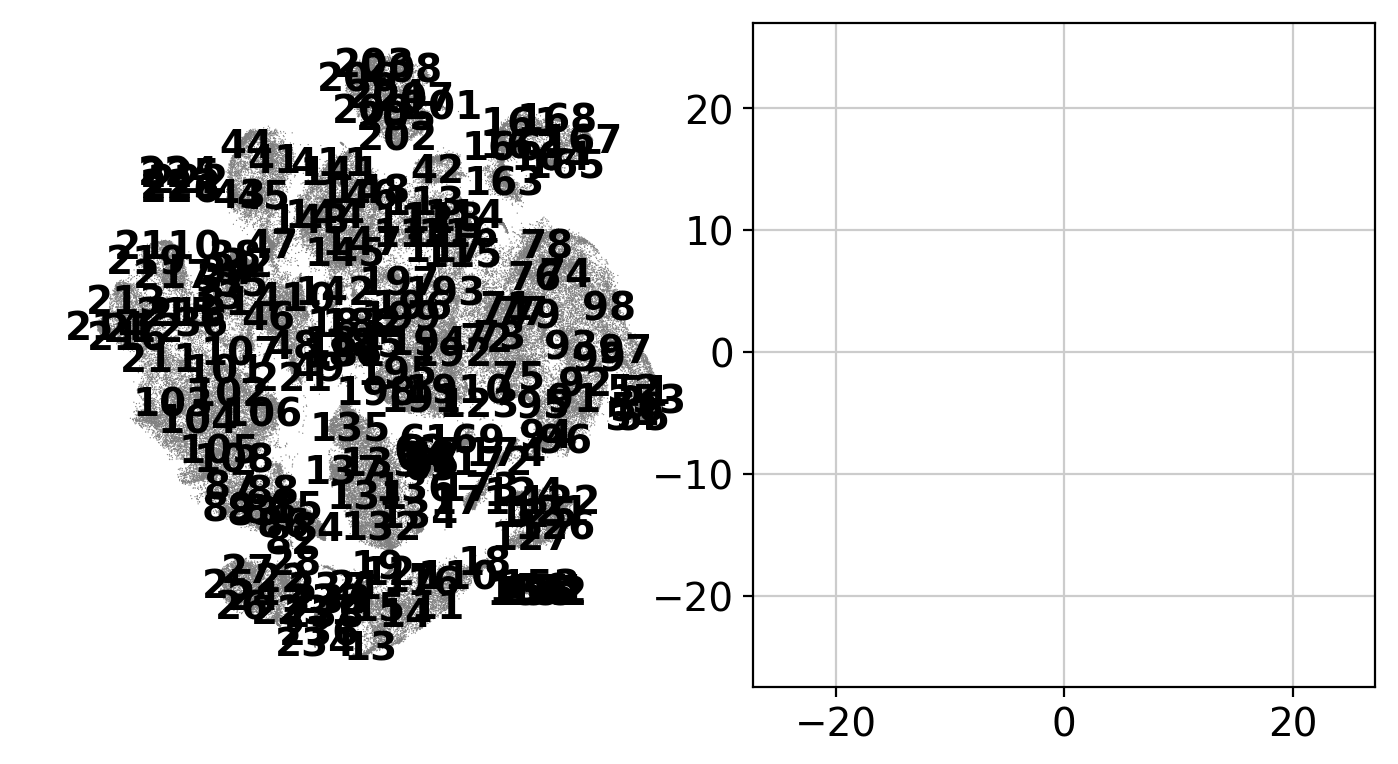

In [31]:
##======  Compute PAGA using the diffusion maps space ======##

sc.pp.neighbors(adata,n_neighbors=15,use_rep='X_diffmap')
sc.tl.paga(adata, groups='clusterSubUnique')


sc.pl.paga_compare(adata, basis='tsne',threshold_solid=0.1,edge_width_scale=0.1)
sc.pl.paga_compare(adata, basis='umap',threshold_solid=0.1,edge_width_scale=0.1)

In [32]:
##==UMAP of clusters when there are 20 clusters==##
## 23 now
all_colours = ["#532C8A","#F7901D","#B51D8D","#F397C0","#C594BF","#DFCDE4","#A0CC47","#3F84AA","#B3793B",
               "#683612","#C72228","#EF4E22","#989898","#333333","#7F6874","#7253A2","#65A83E","#EF5A9D",
               "#FBBE92","#139992","000000","000000","000000"]

In [33]:
adata.obs['clusterSubUnique']
# old dataset had 142 subclusters; increased sequencing bumps this up to 184 subclusters

index
cell_1          41
cell_2          21
cell_4          43
cell_5         102
cell_6          42
              ... 
cell_172991    137
cell_172992    169
cell_172993    131
cell_172994    169
cell_172995    218
Name: clusterSubUnique, Length: 146133, dtype: category
Categories (184, object): [11, 12, 13, 14, ..., 410, 411, 1910, 2110]

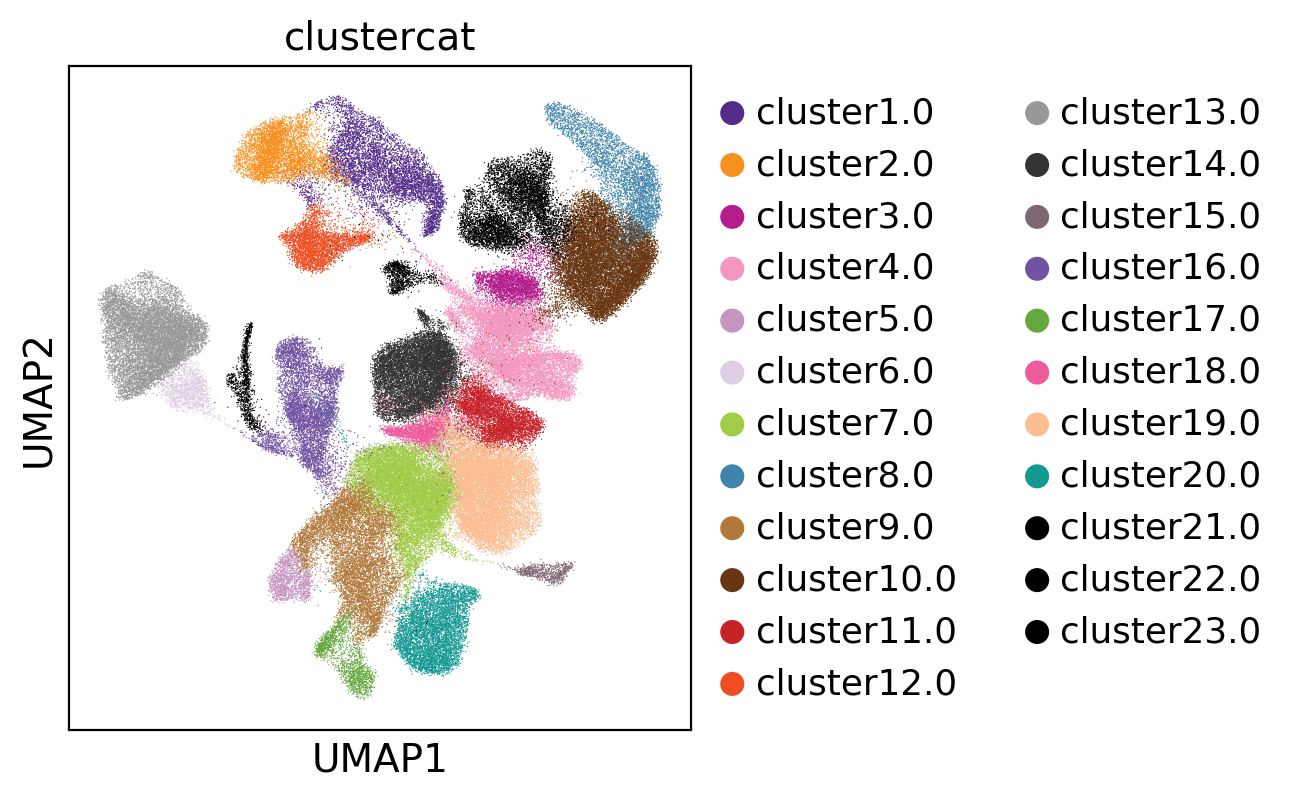

In [34]:
sc.pl.scatter(adata,color='clustercat',basis="umap",palette=all_colours)

In [36]:
new = ['GD9_head' if row['sample'] in [12, 16] else 'GD9_trunk' if row['sample'] in [13, 17] else 'GD9_tail' if row['sample'] in [14,18] else row['stage'] for index, row in adata.obs.iterrows()]
pd.Series(new).value_counts()

GD9          73403
GD8          34686
GD7          13674
GD9_trunk    12137
GD9_tail      9774
GD9_head      2459
dtype: int64

... storing 'stage_res' as categorical


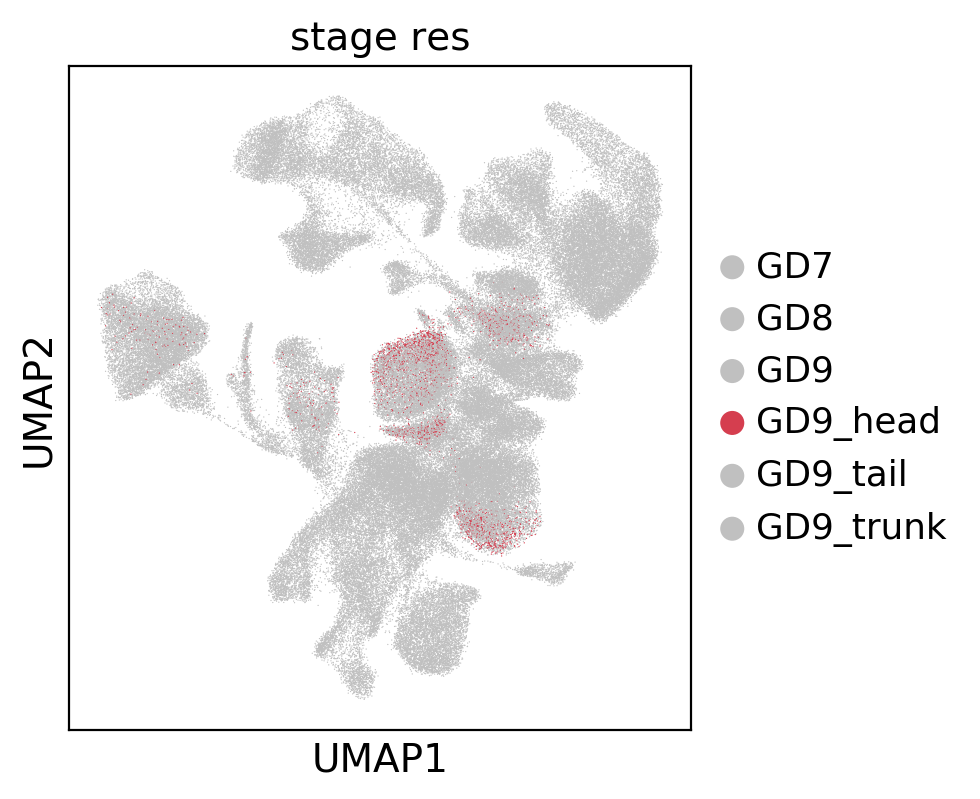

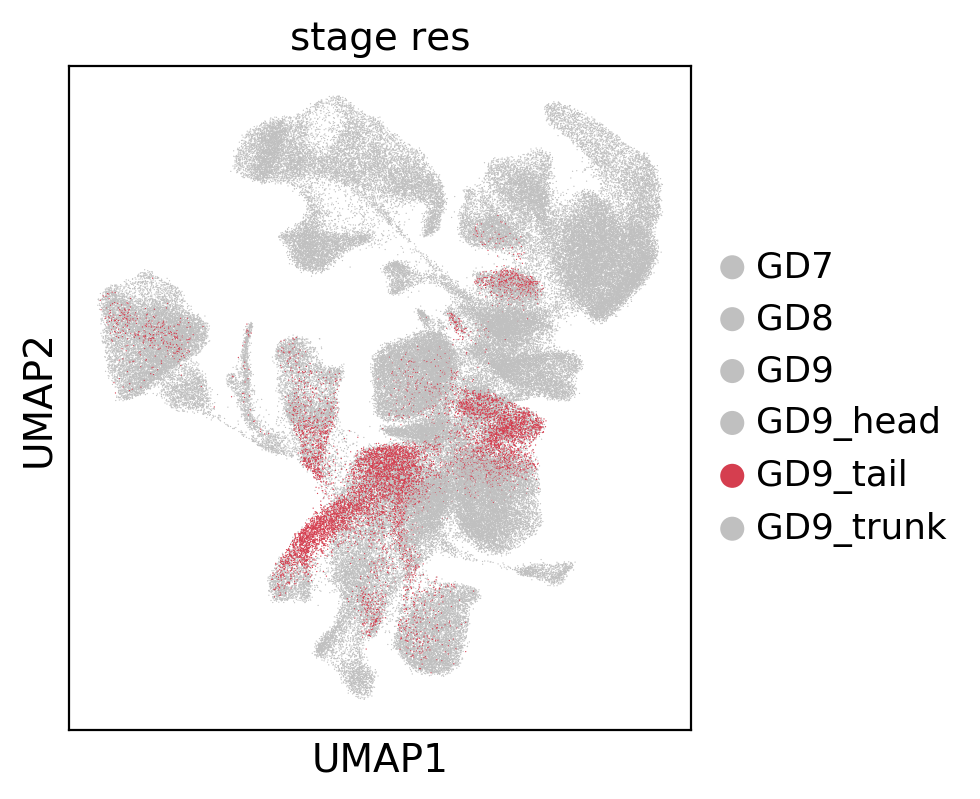

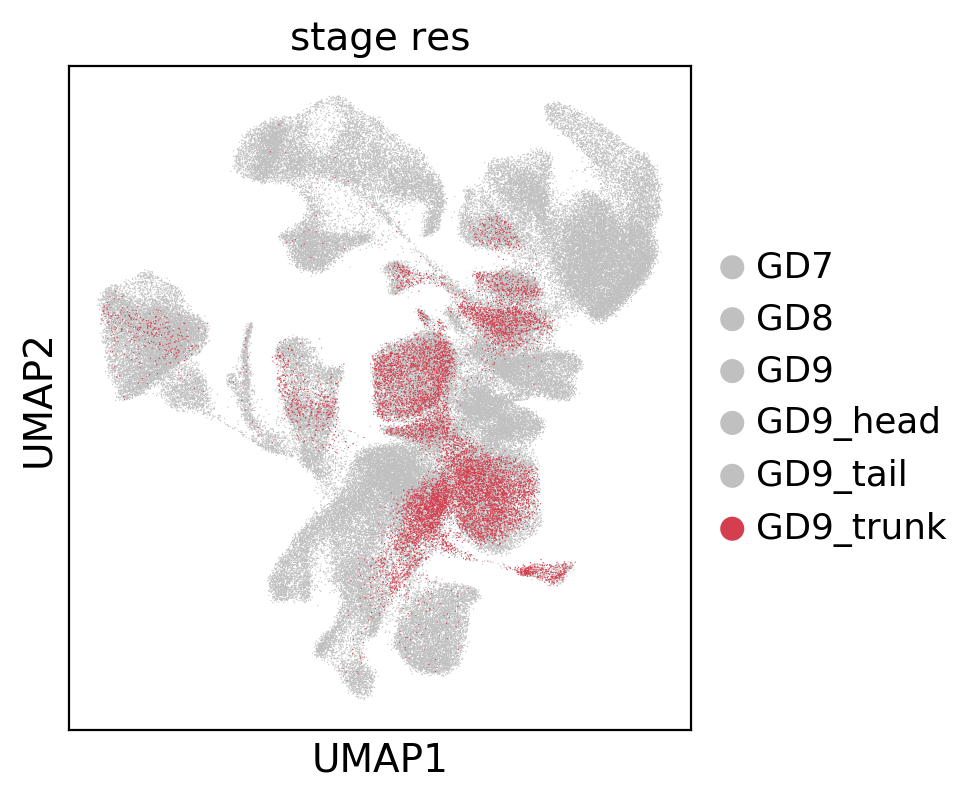

In [37]:
adata.obs['stage_res'] = new
##======  Plot UMAP coloured by time-points ======##
spectralPal = ['#C0C0C0','#C0C0C0','#C0C0C0','#D53E4F','#C0C0C0','#C0C0C0'] 
sc.pl.scatter(adata,color='stage_res',basis="umap",palette=spectralPal)


spectralPal = ['#C0C0C0','#C0C0C0','#C0C0C0','#C0C0C0','#D53E4F','#C0C0C0'] 
sc.pl.scatter(adata,color='stage_res',basis="umap",palette=spectralPal)


spectralPal = ['#C0C0C0','#C0C0C0','#C0C0C0','#C0C0C0','#C0C0C0','#D53E4F'] 
sc.pl.scatter(adata,color='stage_res',basis="umap",palette=spectralPal)

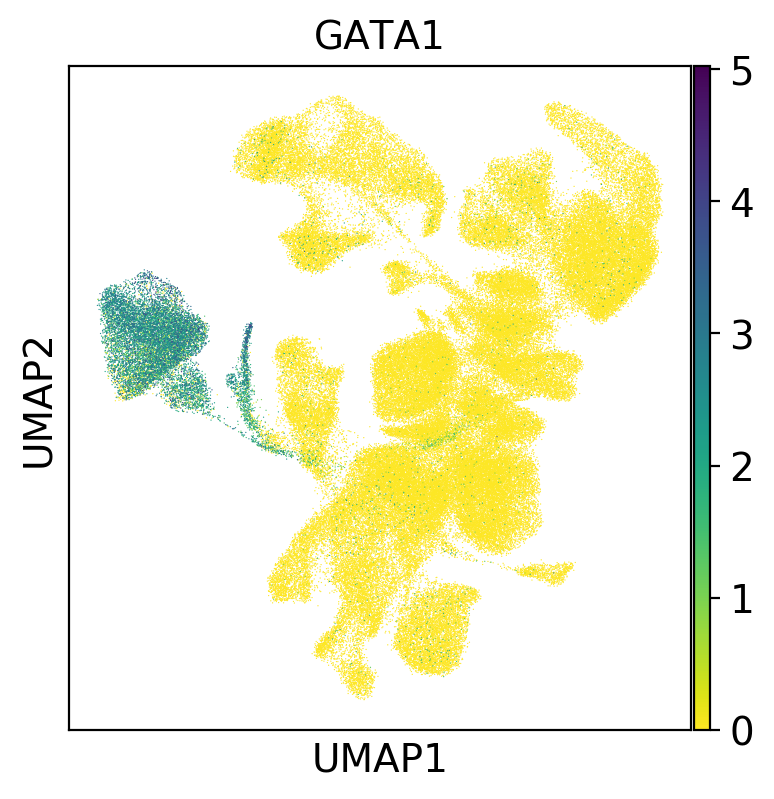

In [38]:
adata.obs["GATA1"]=adata.X[:,adata.var.index=='GATA1'].sum(1)
sc.pl.scatter(adata,color='GATA1',color_map="viridis_r",legend_loc='none',basis="umap")


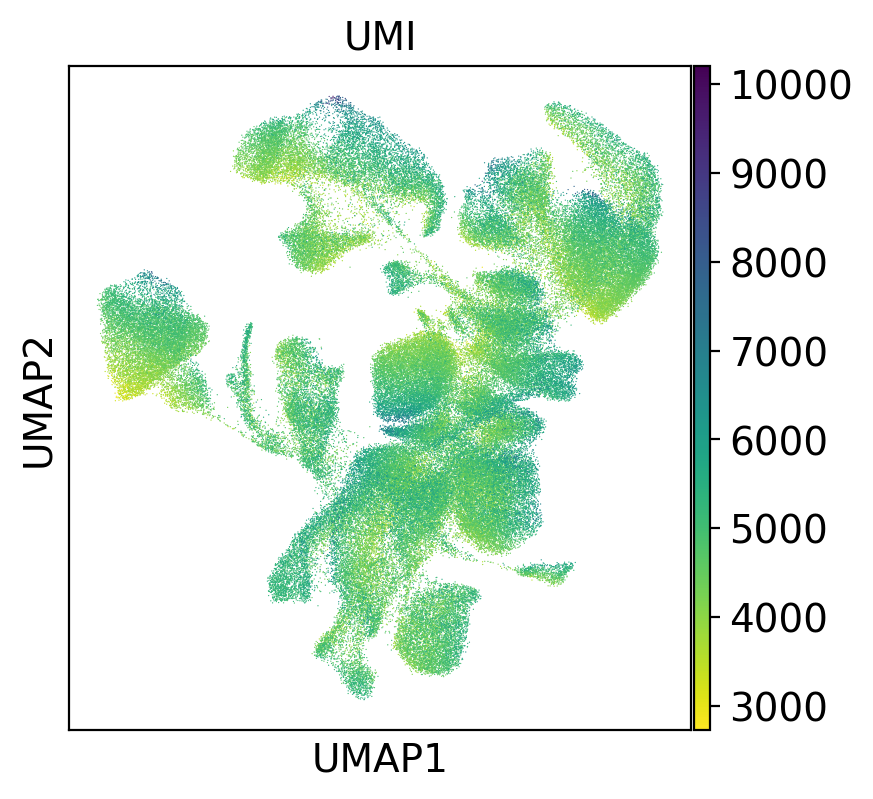

In [47]:
adata.obs["UMI"]=adata.X.sum(1)
sc.pl.scatter(adata,color='UMI',color_map="viridis_r",legend_loc='none',basis="umap")

In [25]:
adata.var[1:10]

geneID
index                                 
RNF183              ENSOCUG00000005054
PRPF4               ENSOCUG00000005046
CDC26               ENSOCUG00000005044
SLC31A1             ENSOCUG00000005040
FKBP15              ENSOCUG00000005028
SLC31A2             ENSOCUG00000026691
ZFP37               ENSOCUG00000029203
ENSOCUG00000026544  ENSOCUG00000026544
SLC46A2             ENSOCUG00000009840

In [19]:
summary = adata.obs["GATA1"].describe()